In [3]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np


In [11]:
def read_file(filename):
    with open(filename, "r") as fp:
        lines = fp.readlines()

    # Define a function to parse a single block of data  
    def parse_block(client_line, jct_line, avg_jct_line):  
        # Extract the number of clients using regex  
        clients_num_match = re.search(r'clients_num:\s*(\d+)', client_line)  
        if clients_num_match:  
            clients_num = int(clients_num_match.group(1))  
        else:  
            raise ValueError("Number of clients not found")  

        # Extract the JCT dictionary  
        jct_data = eval(jct_line.strip())  

        # Extract the average JCT using regex  
        avg_jct_match = re.search(r'Avg\. JCT ([\d.]+) \(s\)', avg_jct_line)  
        if avg_jct_match:  
            avg_jct = float(avg_jct_match.group(1))  
        else:  
            raise ValueError("Average JCT not found")  

        return clients_num, jct_data, avg_jct  

    # Iterate over the lines and parse each block of data  
    parsed_data = []  
    for i in range(1, len(lines), 3):  
        clients_num, jct_data, avg_jct = parse_block(lines[i], lines[i+1], lines[i+2])  
        parsed_data.append({  
            'clients_num': clients_num,  
            'jct_data': jct_data,  
            'avg_jct': avg_jct  
        })  

    # Display the parsed data  
    for block in parsed_data:  
        print(f"Clients: {block['clients_num']}, Average JCT: {block['avg_jct']} (s)")  
    return parsed_data

In [12]:
parrot = read_file('parrot_main.log')
vllm = read_file('fschat_vllm.log')

Clients: 10, Average JCT: 90.14 (s)
Clients: 15, Average JCT: 124.13 (s)
Clients: 20, Average JCT: 172.52 (s)
Clients: 25, Average JCT: 235.02 (s)
Clients: 10, Average JCT: 115.37 (s)
Clients: 15, Average JCT: 172.21 (s)
Clients: 20, Average JCT: 234.5 (s)
Clients: 25, Average JCT: 293.64 (s)


In [21]:
print('parrot', parrot[3])
# print('vllm', vllm)

parrot {'clients_num': 25, 'jct_data': {1: 157.287814664, 8: 170.473940729, 0: 173.840578573, 6: 179.321610757, 12: 185.955058475, 5: 186.678894288, 9: 188.199501101, 3: 208.53711853, 4: 208.682837096, 2: 214.885902047, 10: 219.818483178, 7: 221.502394783, 13: 224.950206795, 14: 229.079620607, 11: 230.931370055, 15: 244.148339709, 16: 258.301064632, 17: 260.595814719, 18: 267.086336424, 19: 278.265503637, 20: 297.555000522, 21: 303.650385519, 23: 306.058663208, 22: 328.468483128, 24: 331.312660648}, 'avg_jct': 235.02}


In [24]:

client_nums = [10, 15, 20, 25]
systems = ['parrot', 'vllm']
hatches = ['', '\\', '/']
colors = [
"#d73027",
"#4575b4"]

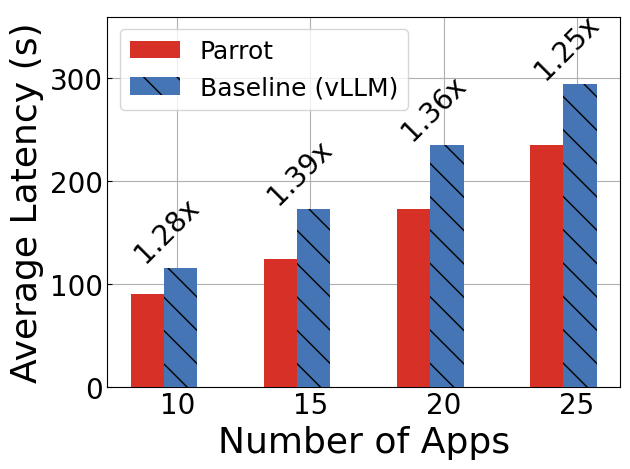

In [39]:
# Organize the data
data = {
    "parrot": parrot,
    "vllm": vllm,
}

names = {
    "parrot": "Parrot",
    "vllm": "Baseline (vLLM)",
}

# statistics = {ol: {s: [] for s in systems} for ol in client_nums}

# for system, system_data in data.items():
#     for key, value in system_data.items():
#         chunk_size = key[1]
#         statistics[chunk_size][system].append(value)

# Calculate statistics
# averages = {ol: {s: np.mean(values) for s, values in ol_data.items()} for ol, ol_data in statistics.items()}
# mins = {ol: {s: np.min(values) for s, values in ol_data.items()} for ol, ol_data in statistics.items()}
# maxs = {ol: {s: np.max(values) for s, values in ol_data.items()} for ol, ol_data in statistics.items()}

# Generate the chart
x = np.arange(len(client_nums))
width = 0.25

fig, ax = plt.subplots()


plt.grid(True)
for i in range(len(client_nums)):
    assert data['parrot'][i]['clients_num'] == client_nums[i]
    assert data['vllm'][i]['clients_num'] == client_nums[i]
for i, system in enumerate(systems):
    
    avg = [data[system][_]['avg_jct'] for _ in range(len(client_nums))]
#     min_ = [mins[ol][system] for ol in client_nums]
#     max_ = [maxs[ol][system] for ol in client_nums]
    
    rects = ax.bar(x - width/2 + i*width, avg, width,  hatch = hatches[i], color = colors[i], label=names[system],zorder=3) # hatches
    
    # Add speedup values
    if system != 'parrot':
        speedup_values = [data[system][_]['avg_jct']/data['parrot'][_]['avg_jct'] for _ in range(len(client_nums))]
        for rect, speedup in zip(rects, speedup_values):
            height = rect.get_height()
            diff = 0.1 if system == 'vllm' else -0.1
            ax.text(rect.get_x() + rect.get_width() / 2 -diff, height,
                    '{:.2f}x'.format(speedup),
                    ha='center', va='bottom', rotation=45,
                    fontsize=20)
            
plt.legend(loc='upper left', prop = { "size": 18 },)
ax.tick_params(axis='y', labelsize=20, direction='in')
ax.tick_params(axis='x', labelsize=20, direction='in')
ax.set_xlabel('Number of Apps', fontsize=26)
ax.set_ylabel('Average Latency (s)', fontsize=26)
ax.set_xticks([_+0.1 for _ in x])
ax.set_xticklabels(client_nums)
plt.ylim([0,359])

fig.tight_layout()

plt.savefig('chain-multi.pdf')